In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Set random seed for reproducibility
np.random.seed(42)

# Parameters
num_classes = 4
samples_per_class = 25000  # Total samples: 100,000
signal_length = 128        # Number of samples per signal

# Frequency components for each class (in Hz)
frequencies = [5, 10, 15, 20]

# Sampling rate
fs = 100  # Sampling rate in Hz

# Time vector
t = np.arange(signal_length) / fs  # Duration: 1.28 seconds

In [2]:
def generate_complex_signal(frequency, noise_level=0.1):
    """
    Generates a complex-valued sinusoidal signal with noise.

    Args:
        frequency (float): Frequency of the sinusoid in Hz.
        noise_level (float): Standard deviation of the Gaussian noise.

    Returns:
        np.ndarray: Complex-valued signal of shape (signal_length,).
    """
    # Real part: cosine wave
    real = np.cos(2 * np.pi * frequency * t)

    # Imaginary part: sine wave
    imag = np.sin(2 * np.pi * frequency * t)

    # Add Gaussian noise
    real += np.random.normal(0, noise_level, signal_length)
    imag += np.random.normal(0, noise_level, signal_length)

    return real + 1j * imag

# Generate data for each class
data = []
labels = []

for class_idx, freq in enumerate(frequencies):
    for _ in range(samples_per_class):
        signal = generate_complex_signal(freq)
        data.append(signal)
        labels.append(class_idx)

# Convert to numpy arrays
data = np.array(data)      # Shape: (100000, 128)
labels = np.array(labels)  # Shape: (100000,)

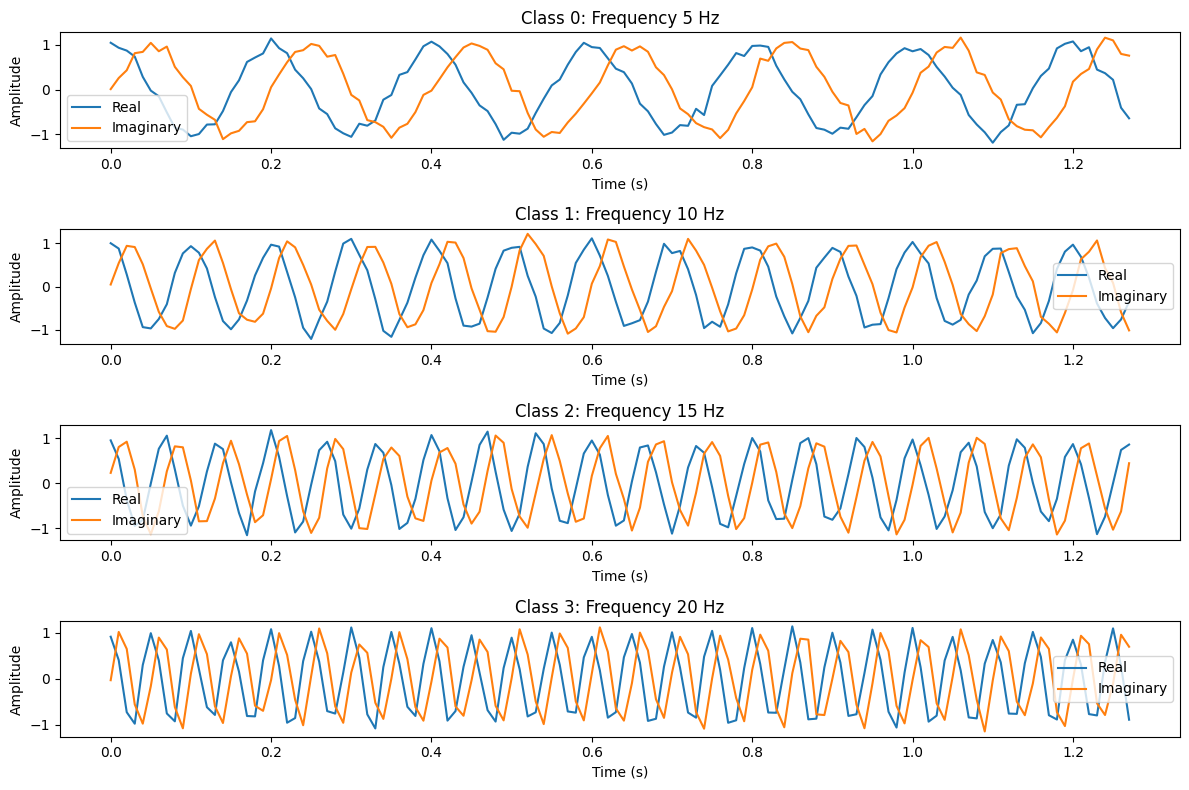

In [3]:
plt.figure(figsize=(12, 8))

for class_idx, freq in enumerate(frequencies):
    plt.subplot(num_classes, 1, class_idx + 1)
    plt.plot(t, data[labels == class_idx][0].real, label='Real')
    plt.plot(t, data[labels == class_idx][0].imag, label='Imaginary')
    plt.title(f'Class {class_idx}: Frequency {freq} Hz')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()

plt.tight_layout()
plt.show()

In [4]:
print(f"Total samples: {data.shape[0]}")
print(f"Signal length: {data.shape[1]} samples")
print(f"Number of classes: {num_classes}")

# Check class distribution
unique, counts = np.unique(labels, return_counts=True)
class_distribution = dict(zip(unique, counts))
print("Class distribution:", class_distribution)

Total samples: 100000
Signal length: 128 samples
Number of classes: 4
Class distribution: {0: 25000, 1: 25000, 2: 25000, 3: 25000}


In [5]:
from sklearn.model_selection import train_test_split

# First, split into Train+Val and Test
X_train_val, X_test, y_train_val, y_test = train_test_split(
    data, labels, test_size=0.15, random_state=42, stratify=labels
)

# Then, split Train+Val into Train and Val
val_size = 0.15 / (1 - 0.15)  # Adjusted validation size
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=val_size, random_state=42, stratify=y_train_val
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Training set: 69999 samples
Validation set: 15001 samples
Test set: 15000 samples


In [6]:
from sklearn.preprocessing import StandardScaler

def normalize_data(X_train, X_val, X_test):
    """
    Normalizes the real and imaginary parts of the complex signals.

    Args:
        X_train (numpy.ndarray): Training data.
        X_val (numpy.ndarray): Validation data.
        X_test (numpy.ndarray): Test data.

    Returns:
        Tuple: Normalized X_train, X_val, X_test
    """
    # Separate real and imaginary parts
    X_train_real = X_train.real
    X_train_imag = X_train.imag
    X_val_real = X_val.real
    X_val_imag = X_val.imag
    X_test_real = X_test.real
    X_test_imag = X_test.imag

    # Reshape to 2D for scaler: (num_samples * channels, features)
    num_train, samples = X_train_real.shape
    num_val, _ = X_val_real.shape
    num_test, _ = X_test_real.shape

    X_train_combined = np.vstack((X_train_real, X_train_imag))  # Shape: (2*num_train, samples)
    X_val_combined = np.vstack((X_val_real, X_val_imag))        # Shape: (2*num_val, samples)
    X_test_combined = np.vstack((X_test_real, X_test_imag))     # Shape: (2*num_test, samples)

    scaler = StandardScaler()
    scaler.fit(X_train_combined)

    X_train_norm_real = scaler.transform(X_train_real)
    X_train_norm_imag = scaler.transform(X_train_imag)
    X_val_norm_real = scaler.transform(X_val_real)
    X_val_norm_imag = scaler.transform(X_val_imag)
    X_test_norm_real = scaler.transform(X_test_real)
    X_test_norm_imag = scaler.transform(X_test_imag)

    # Stack real and imaginary parts as separate channels
    X_train_norm = np.stack((X_train_norm_real, X_train_norm_imag), axis=1)  # Shape: (num_train, 2, 128)
    X_val_norm = np.stack((X_val_norm_real, X_val_norm_imag), axis=1)        # Shape: (num_val, 2, 128)
    X_test_norm = np.stack((X_test_norm_real, X_test_norm_imag), axis=1)     # Shape: (num_test, 2, 128)

    return X_train_norm, X_val_norm, X_test_norm

# Normalize the data
X_train_norm, X_val_norm, X_test_norm = normalize_data(X_train, X_val, X_test)

In [7]:
import torch
from torch.utils.data import Dataset, DataLoader

class SyntheticComplexDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Array of shape (num_samples, 2, 128)
            y (numpy.ndarray): Array of shape (num_samples,)
        """
        self.X = torch.tensor(X, dtype=torch.float32)  # Convert to tensor
        self.y = torch.tensor(y, dtype=torch.long)     # Convert to tensor

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        # x is of shape (2, 128): [Real, Imaginary]
        x = self.X[idx]       # (2, 128)
        y = self.y[idx]       # Scalar
        return x, y

In [8]:
# Create Dataset instances
train_dataset = SyntheticComplexDataset(X_train_norm, y_train)
val_dataset = SyntheticComplexDataset(X_val_norm, y_val)
test_dataset = SyntheticComplexDataset(X_test_norm, y_test)

In [9]:
# Create DataLoaders
batch_size = 1024

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleComplexCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(SimpleComplexCNN, self).__init__()
        # Convolutional Layers
        self.conv1 = nn.Conv2d(in_channels=2, out_channels=16, kernel_size=(3, 3), padding=(1, 1))
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=(1, 2))  # Pool only along width

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=(1, 1))
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=(1, 2))  # Pool only along width

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=(1, 1))
        self.act3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=(1, 2))  # Pool only along width

        # Fully Connected Layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(in_features=64 * 1 * 16, out_features=128)  # Adjust based on pooling
        self.act4 = nn.ReLU()
        self.fc2 = nn.Linear(in_features=128, out_features=num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        """
        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, 2, 1, 128)

        Returns:
            torch.Tensor: Output probabilities of shape (batch_size, num_classes)
        """
        # Convolutional Layers
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.act3(x)
        x = self.pool3(x)

        # Flatten
        x = self.flatten(x)

        # Fully Connected Layers
        x = self.fc1(x)
        x = self.act4(x)
        x = self.fc2(x)

        # Softmax
        x = self.softmax(x)
        return x

In [11]:
from torchsummary import summary

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate the model
model = SimpleComplexCNN(num_classes=num_classes).to(device)
print(model)

# Print model summary
summary(model, input_size=(2, 1, 128))

SimpleComplexCNN(
  (conv1): Conv2d(2, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (pool1): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (pool2): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (pool3): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=1024, out_features=128, bias=True)
  (act4): ReLU()
  (fc2): Linear(in_features=128, out_features=4, bias=True)
  (softmax): Softmax(dim=1)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 1, 128]             304
    

In [12]:
import torch.optim as optim

# Define loss function
criterion = nn.CrossEntropyLoss()

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [13]:
import time

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25, device='cpu'):
    """
    Trains the model and validates it at each epoch.

    Args:
        model (nn.Module): The neural network model.
        train_loader (DataLoader): DataLoader for training data.
        val_loader (DataLoader): DataLoader for validation data.
        criterion: Loss function.
        optimizer: Optimizer.
        num_epochs (int): Number of training epochs.
        device: Device to run the training on.

    Returns:
        nn.Module: The trained model with best validation accuracy.
    """
    since = time.time()
    best_model_wts = None
    best_acc = 0.0
    patience = 5  # Early stopping patience
    trigger_times = 0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = train_loader
            else:
                model.eval()   # Set model to evaluate mode
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0
            total_samples = 0

            # Iterate over data
            for inputs, labels in dataloader:
                # Reshape inputs to (batch_size, 2, 1, 128)
                inputs = inputs.unsqueeze(2)  # (batch_size, 2, 1, 128)
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                total_samples += inputs.size(0)

            epoch_loss = running_loss / total_samples
            epoch_acc = running_corrects.double() / total_samples

            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            # Deep copy the model
            if phase == 'val':
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = model.state_dict()
                    trigger_times = 0
                    torch.save(model.state_dict(), 'best_simple_cvnn_model.pth')
                    print("Best model saved.")
                else:
                    trigger_times += 1
                    print(f"Trigger Times: {trigger_times}")
                    if trigger_times >= patience:
                        print("Early stopping!")
                        time_elapsed = time.time() - since
                        print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
                        print(f"Best val Acc: {best_acc:.4f}")
                        # Load best model weights
                        model.load_state_dict(best_model_wts)
                        return model
        print()

    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best val Acc: {best_acc:.4f}")

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [14]:
# Define number of epochs
num_epochs = 30

# Start training
trained_model = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs, device=device)

Epoch 1/30
----------
Train Loss: 0.9180 Acc: 0.9386
Val Loss: 0.7437 Acc: 1.0000
Best model saved.

Epoch 2/30
----------
Train Loss: 0.7437 Acc: 1.0000
Val Loss: 0.7437 Acc: 1.0000
Trigger Times: 1

Epoch 3/30
----------
Train Loss: 0.7437 Acc: 1.0000
Val Loss: 0.7437 Acc: 1.0000
Trigger Times: 2

Epoch 4/30
----------
Train Loss: 0.7437 Acc: 1.0000
Val Loss: 0.7437 Acc: 1.0000
Trigger Times: 3

Epoch 5/30
----------
Train Loss: 0.7437 Acc: 1.0000
Val Loss: 0.7437 Acc: 1.0000
Trigger Times: 4

Epoch 6/30
----------
Train Loss: 0.7437 Acc: 1.0000
Val Loss: 0.7437 Acc: 1.0000
Trigger Times: 5
Early stopping!
Training complete in 0m 29s
Best val Acc: 1.0000


In [15]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(model, test_loader, criterion, device='cpu', class_names=None):
    """
    Evaluates the model on the test set.

    Args:
        model (nn.Module): The trained model.
        test_loader (DataLoader): DataLoader for test data.
        criterion: Loss function.
        device: Device to run the evaluation on.
        class_names (list): List mapping label indices to class names.
    """
    model.to(device)
    model.eval()

    running_loss = 0.0
    running_corrects = 0
    total_samples = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            # Reshape inputs to (batch_size, 2, 1, 128)
            inputs = inputs.unsqueeze(2)  # (batch_size, 2, 1, 128)
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            total_samples += inputs.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_loss = running_loss / total_samples
    test_acc = running_corrects.double() / total_samples

    print(f"Test Loss: {test_loss:.4f} Acc: {test_acc:.4f}\n")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    print("\n")

    # Classification Report
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

Test Loss: 0.7437 Acc: 1.0000



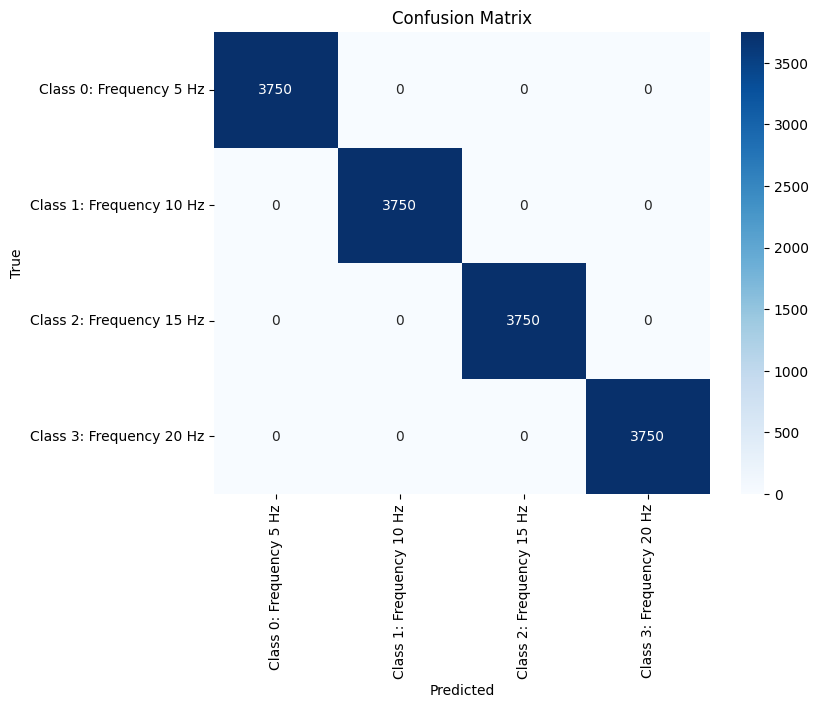



Classification Report:
                          precision    recall  f1-score   support

 Class 0: Frequency 5 Hz       1.00      1.00      1.00      3750
Class 1: Frequency 10 Hz       1.00      1.00      1.00      3750
Class 2: Frequency 15 Hz       1.00      1.00      1.00      3750
Class 3: Frequency 20 Hz       1.00      1.00      1.00      3750

                accuracy                           1.00     15000
               macro avg       1.00      1.00      1.00     15000
            weighted avg       1.00      1.00      1.00     15000



In [16]:
# Define class names
class_names = [
    'Class 0: Frequency 5 Hz',
    'Class 1: Frequency 10 Hz',
    'Class 2: Frequency 15 Hz',
    'Class 3: Frequency 20 Hz'
]

# Define loss function for evaluation
test_criterion = nn.CrossEntropyLoss()

# Evaluate the trained model
evaluate_model(trained_model, test_loader, test_criterion, device=device, class_names=class_names)